In [3]:
import os
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt


In [4]:
from pyrep import PyRep
from pyrep.robots.arms.sawyer import Sawyer
from pyrep.robots.end_effectors.baxter_gripper import BaxterGripper
from pyrep.objects.proximity_sensor import ProximitySensor
from pyrep.objects.vision_sensor import VisionSensor
from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape
from pyrep.objects.dummy import Dummy

In [5]:
#pyrep wrapper is requried 
pr = PyRep()

#path the the coppelia scene file that includes a chessboard pattern for calibration 
SCENE_FILE = './scenes/camera_calibration_checkerboard_plane_wcamera.ttt'
#SCENE_FILE = './scenes/camera_calibration_checkerboard_plane.ttt'

#launch the scene and start the simulation
pr.launch(SCENE_FILE)
pr.start()
pr.step()

In [7]:
#get the scene object handles
tip_target = Dummy('Sawyer_tip')
vs_front = VisionSensor('Vision_front')
chessboard = Shape('Plane')

In [8]:
# helper functions to capture images from copppelias vision sensors
def capture_rgb():
    rgb = vs_front.capture_rgb() * 255
    rgb = rgb.astype(np.uint8)
    return rgb
def capture_grey():
    rgb = capture_rgb()
    grey = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
    return grey


In [13]:
#get the initial pos of the tip_target / vs_front
x_in,y_in, z_in = vs_front.get_position()
initial_cam_pos = [x_in, y_in, z_in]
initial_cam_ori = vs_front.get_orientation()

initial_tip_pos = tip_target.get_position()
initial_tip_ori = tip_target.get_orientation()

print('initial_cam_position: ', initial_cam_pos)
print('initial_cam_orientation: ', initial_cam_ori,'\n')

print('initial_tip_position: ', initial_tip_pos)
print('initial_tip_orientation: ', initial_tip_ori)

initial_cam_position:  [0.0, 0.0, 0.20000000298023224]
initial_cam_orientation:  [-3.1415925  0.         0.       ] 

initial_tip_position:  [0.  0.  0.2]
initial_tip_orientation:  [-3.1415925  0.         0.       ]


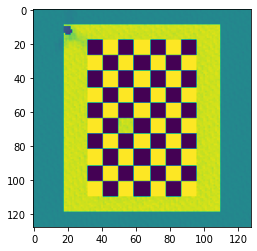

captured_img.shape:  (128, 128)


In [12]:
img=capture_grey()
plt.imshow(img)
plt.show()
print('captured_img.shape: ', img.shape)

In [14]:
#helper functions to move the vision sensor

def move_cam_randomly(tip_target, initial_cam_pos):

    del_x = -0.04 + np.random.rand()*0.08
    del_y = -0.04 + np.random.rand()*0.08
    
    x_in, y_in, z_in = initial_cam_pos
    
    xh = x_in+del_x
    yh = y_in+del_y
    zh = z_in
    
    tip_target.set_position([xh,yh,zh])
    pr.step()
    
def rotate_camera_randomly(tip_target, initial_cam_ori):
    del_theta_min = -1.5 #degrees
    del_theta_max =  1.5 #degrees
    
    del_alpha_deg = del_theta_min+np.random.rand()*2*del_theta_max
    del_beta_deg = del_theta_min+np.random.rand()*2*del_theta_max
    del_gamma_deg = del_theta_min+np.random.rand()*2*del_theta_max
    
    del_alpha_rad = del_alpha_deg*np.pi/180
    del_beta_rad = del_beta_deg*np.pi/180
    del_gamma_rad = del_gamma_deg*np.pi/180
    
    target_ori = np.array([del_alpha_rad, del_beta_rad, del_gamma_rad])+initial_cam_ori
    
    tip_target.set_orientation(target_ori)
    pr.step()

def move_cam_randomly_updown(tip_target, initial_cam_pos):
    
    x_in, y_in, z_in = initial_cam_pos
    
    del_z = 0 + np.random.rand()*0.05
    zh = z_in+del_z
    
    tip_target.set_position([x_in,y_in,zh])
    pr.step()
    
def set_cam_height(tip_target, initial_cam_pos, cam_height):
    xh = initial_cam_pos[0]
    yh = initial_cam_pos[0]
    zh = cam_height #in meters
    
    tip_target.set_position([xh, yh, zh])
    pr.step()

In [15]:
#chessboard specs
height = 9
width = 6
square_size = 0.02 #in meters

#initialize object points
objp = np.zeros((height*width, 3), np.float32)
objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)
objp = objp * square_size


In [17]:
#number of images that is used to calculate the cam intrinsics and extrinsics
#interestingly, you get different results for each run

N_img_list = [40,50,60]


In [18]:
%%time

mtx_list   = []
dist_list  = []
rvecs_list = []
tvecs_list = [] 

imgs_list = []
corners_list = []
corners2_list = []

N_ret_issues  = 0

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
for N_img in N_img_list:
    
    objpoints = []
    imgpoints = []
    
    sub_imgs_list = []
    sub_corners_list = []
    sub_corners2_list = []
    
    for i in range(N_img):
        
        #disturb the vision sensor
        move_cam_randomly(tip_target, initial_cam_pos)
        rotate_camera_randomly(tip_target, initial_cam_ori)
        move_cam_randomly_updown(tip_target, initial_cam_pos)
        pr.step()
        
        img = capture_grey()
        ret, corners = cv2.findChessboardCorners(img, (width, height), None)
        sub_corners_list.append(corners)
        
        # If found, add object points, image points (after refining them)
        #imgpoints.append(corners)

        if ret:
            objpoints.append(objp)
            
            #for subpixel accuracy corner detection - debatable if useful
            corners2 = cv2.cornerSubPix(img, corners, (5,5), (-1, -1), criteria)
            imgpoints.append(corners2)
            
            sub_corners2_list.append(corners2)
            sub_imgs_list.append(img)

            # Draw and display the corners
            #draw_detected_corners(img, corners2)
        
        else:
            print('ret_issue')
            N_ret_issues+=1
    
    #read the cv2 docs to understand the outputs
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
    
    imgs_list.append(sub_imgs_list)
    corners_list.append(sub_corners_list)
    corners2_list.append(sub_corners2_list)
    
    mtx_list.append(mtx)
    dist_list.append(dist)
    rvecs_list.append(rvecs)
    tvecs_list.append(tvecs)
    
    print('N_img:{:}'.format(N_img))

ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
N_img:40
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
N_img:50
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
ret_issue
N_img:60
CPU times: user 33.4 s, sys: 843 ms, total: 34.2 s
Wall time: 35.5 s


In [19]:
fx = [x[0][0] for x in mtx_list]
fy = [x[1][1] for x in mtx_list]
cx = [x[0][2] for x in mtx_list]
cy = [x[1][2] for x in mtx_list]

fx_mean = np.array(fx).mean()
fy_mean = np.array(fy).mean()
cx_mean = np.array(cx).mean()
cy_mean = np.array(cy).mean()

fx_median = np.median(np.array(fx))
fy_median = np.median(np.array(fy))
cx_median = np.median(np.array(cx))
cy_median = np.median(np.array(cy))

print('fx_mean = ', fx_mean)
print('fy_mean = ', fy_mean)
print('cx_mean = ', cx_mean)
print('cy_mean = ', cy_mean)
print()
print('fx_median = ', fx_median)
print('fy_median = ', fy_median)
print('cx_median = ', cx_median)
print('cy_median = ', cy_median)

fx_mean =  96.69022551364957
fy_mean =  96.35145108202612
cx_mean =  63.49752448394732
cy_mean =  60.06080558785592

fx_median =  94.91201657498206
fy_median =  94.76503336506106
cx_median =  63.43399793167728
cy_median =  61.781605212999295


In [20]:
#theoretical solution

fov = 70 * np.pi/180
d = 128
#d = 512

f = d/2/np.tan(fov/2)
print('f [pix] : ', f)


f [pix] :  91.40147243149534


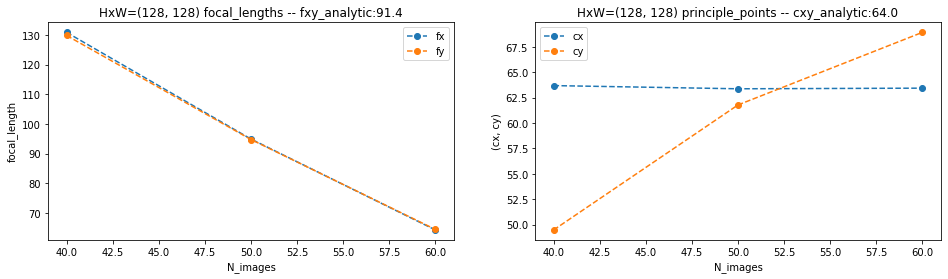

In [21]:
fig = plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(N_img_list, fx, 'o--', label = 'fx')
plt.plot(N_img_list, fy, 'o--', label = 'fy')
plt.xlabel('N_images')
plt.ylabel('focal_length')
plt.title('HxW='+ str(img.shape)+' focal_lengths -- fxy_analytic:' + str(np.round(f,2)) )
plt.legend()

plt.subplot(122)
plt.plot(N_img_list, cx, 'o--', label = 'cx')
plt.plot(N_img_list, cy, 'o--', label = 'cy')

plt.xlabel('N_images')
plt.ylabel('(cx, cy)')
plt.title('HxW='+ str(img.shape)+' principle_points -- cxy_analytic:'+str(np.round(d/2,2)))
plt.legend()

plt.show()